In [200]:
print('What\'s up?')

What's up?


### __Notebook Imports__

In [0]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split


%matplotlib inline


## __Gather Data__

#### __Uploading Files__

In [0]:
# Uploading files from the local machine
from zipfile import ZipFile
file1 = '/content/spam_1.zip'
file2 = '/content/spam_2.zip'
file3 = '/content/easy_ham_1.zip'
file4 = '/content/easy_ham_2.zip'

def extracting_files(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print(file_name, 'is extracted')

In [203]:
extracting_files(file_name=file1)
extracting_files(file_name=file2)
extracting_files(file_name=file3)
extracting_files(file_name=file4)

/content/spam_1.zip is extracted
/content/spam_2.zip is extracted
/content/easy_ham_1.zip is extracted
/content/easy_ham_2.zip is extracted


### __Constants__

In [0]:
EXAMPLE_FILE = '/content/practice_email.txt'

SPAM_1_PATH = '/content/spam_1'
SPAM_2_PATH = '/content/spam_2'
EASY_NONSPAM_1_PATH = '/content/easy_ham_1'
EASY_NONSPAM_2_PATH = '/content/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = '/content/email-text-data.json'
WORD_ID_FILE = '/content/word-by-id.csv'

TRAINING_DATA_FILE = '/content/train-data.txt'
TEST_DATA_FILE = '/content/test-data.txt'

WHALE_FILE = '/content/whale-icon.png'
SKULL_FILE = '/content/skull-icon.png'
THUMBS_UP_FILE = '/content/thumbs-up.png'
THUMBS_DOWN_FILE = '/content/thumbs-down.png'
CUSTOM_FONT_FILE = '/content/OpenSansCondensed-Bold.ttf'


### __Reading Files__

In [205]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [206]:
# check which encoding system do we have
import sys
sys.getfilesystemencoding()

'utf-8'

In [207]:
# We want to modify the code in order to get only a message body
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line == '\n':
    is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)
# print(lines)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

### __Generator Functions__

In [0]:
def generate_squares(N):
  for my_number in range(N):
    yield my_number ** 2

In [209]:
for i in generate_squares(5):
  print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

#### __Email body extraction__

In [0]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:
      
      filepath = join(root, file_name)

      stream = open(filepath, encoding='latin-1')

      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == '\n':
          is_body = True

      stream.close()

      email_body = '\n'.join(lines)

      yield file_name, email_body
  


In [0]:
def df_from_directory(path, classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)

  return pd.DataFrame(rows, index=row_names)

In [212]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00129.1080cea3a532759b015dc071d033749d,Removal instructions below\n\n\n\n\n\nI saw yo...,1
00212.a9947ad74a529a35d11538e1df60cd73,<HTML><HEAD>\n\n<META http-equiv=3DContent-Typ...,1
00203.3956f8506171ffd90a0060cafad4fdea,This is a multi-part message in MIME format.\n...,1
00130.c8128e89eff5b0e61aa864ebfd96afba,<!-- saved from url=(0022)http://internet.e-ma...,1
00421.ca2fe949a956845a9ba81c649a7db6c0,This is a multi-part message in MIME format.\n...,1


In [213]:
spam_emails.shape

(1898, 2)

In [214]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [215]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is', data.shape)
data.head()

Shape of entire dataframe is (5799, 2)


,MESSAGE,CATEGORY
00129.1080cea3a532759b015dc071d033749d,Removal instructions below\n\n\n\n\n\nI saw yo...,1
00212.a9947ad74a529a35d11538e1df60cd73,<HTML><HEAD>\n\n<META http-equiv=3DContent-Typ...,1
00203.3956f8506171ffd90a0060cafad4fdea,This is a multi-part message in MIME format.\n...,1
00130.c8128e89eff5b0e61aa864ebfd96afba,<!-- saved from url=(0022)http://internet.e-ma...,1
00421.ca2fe949a956845a9ba81c649a7db6c0,This is a multi-part message in MIME format.\n...,1


In [216]:
data.tail()

,MESSAGE,CATEGORY
01284.d66303890ebecd4423489414ca3d3b6e,"Hi....\n\n\n\nIf you havent already, spamd has...",0
00086.fb3bca2671d0ce43431a201beb3cb268,"On Fri, 19 Jul 2002, kevin lyda wrote:\n\n\n\n...",0
00474.6a69eedbd1b342153a9b1ece91837a9a,"Thanks lads,\n\n\n\nI didn't mean to criticise...",0
00690.dd9bb1e5bc14e171cfc67e0ab3ac850f,--==_Exmh_834464772P\n\nContent-Type: text/pla...,0
01262.7b18594e0276a4cb593a6408afa9c636,"On Mon, 2002-08-19 at 22:34, Angles Puglisi wr...",0


We downloaded our files from the local machine, extracted relevant data (email bodies), and converted them into one dataframe

## __Data Cleaning: Checking for Missing Values__

In [217]:
# check if any message bodies are null 
data['MESSAGE'].isnull().values.any()

False

so, we have no missing values. However, the missing values are not the same as empty values

In [0]:
my_var = None

In [219]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

So, there are some empty emails

In [220]:
(data.MESSAGE.str.len() == 0).any().sum()

1

only one email is empty

### __Locate empty emails__

In [221]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [222]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [223]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

### __Remove System File Entries from Dataframe__

In [0]:
data.drop(['cmds'], inplace=True)

In [225]:
data.shape

(5796, 2)

### __Add Document IDs to Track Emails in Dataset__

In [0]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [227]:
data.DOC_ID

00129.1080cea3a532759b015dc071d033749d       0
00212.a9947ad74a529a35d11538e1df60cd73       1
00203.3956f8506171ffd90a0060cafad4fdea       2
00130.c8128e89eff5b0e61aa864ebfd96afba       3
00421.ca2fe949a956845a9ba81c649a7db6c0       4
                                          ... 
01284.d66303890ebecd4423489414ca3d3b6e    5791
00086.fb3bca2671d0ce43431a201beb3cb268    5792
00474.6a69eedbd1b342153a9b1ece91837a9a    5793
00690.dd9bb1e5bc14e171cfc67e0ab3ac850f    5794
01262.7b18594e0276a4cb593a6408afa9c636    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [228]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,Removal instructions below\n\n\n\n\n\nI saw yo...,1,00129.1080cea3a532759b015dc071d033749d
1,<HTML><HEAD>\n\n<META http-equiv=3DContent-Typ...,1,00212.a9947ad74a529a35d11538e1df60cd73
2,This is a multi-part message in MIME format.\n...,1,00203.3956f8506171ffd90a0060cafad4fdea
3,<!-- saved from url=(0022)http://internet.e-ma...,1,00130.c8128e89eff5b0e61aa864ebfd96afba
4,This is a multi-part message in MIME format.\n...,1,00421.ca2fe949a956845a9ba81c649a7db6c0


In [229]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"Hi....\n\n\n\nIf you havent already, spamd has...",0,01284.d66303890ebecd4423489414ca3d3b6e
5792,"On Fri, 19 Jul 2002, kevin lyda wrote:\n\n\n\n...",0,00086.fb3bca2671d0ce43431a201beb3cb268
5793,"Thanks lads,\n\n\n\nI didn't mean to criticise...",0,00474.6a69eedbd1b342153a9b1ece91837a9a
5794,--==_Exmh_834464772P\n\nContent-Type: text/pla...,0,00690.dd9bb1e5bc14e171cfc67e0ab3ac850f
5795,"On Mon, 2002-08-19 at 22:34, Angles Puglisi wr...",0,01262.7b18594e0276a4cb593a6408afa9c636


## __Save to File using Pandas__

In [0]:
data.to_json(DATA_JSON_FILE)

## __Number of Spam Messages Visualised (Pie Charts)__

In [231]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [0]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

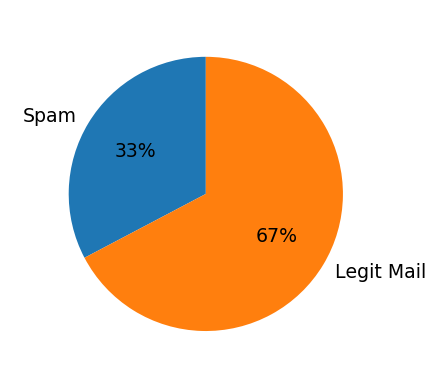

In [233]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%')
plt.show()

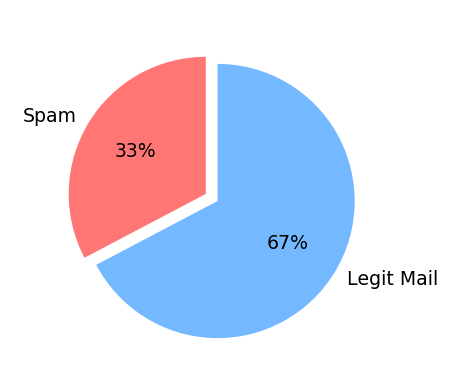

In [234]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

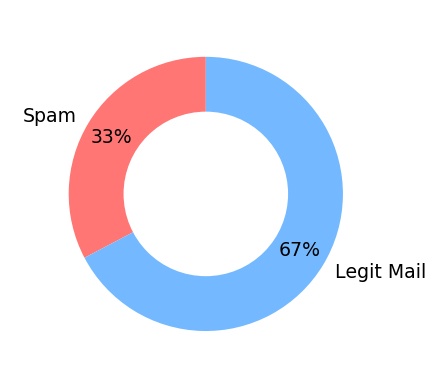

In [235]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

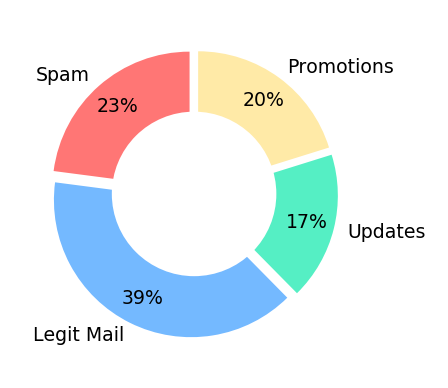

In [236]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## __Natural Language Processing__


### __Text Pre-Processing__

In [237]:
# convert to lower case
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### __Download the NLTK Resources (Tokenizer & Stopwords)__

In [238]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [239]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [240]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### __Tokenising__



In [241]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### __Removing Stop Words__

In [0]:
stop_words = set(stopwords.words('english'))

In [243]:
type(stop_words)

set

In [244]:
if 'this' in stop_words: print('Found it!')

Found it!


In [245]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    
    filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### __Word Stems and Stemming__

In [246]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. \
Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## __Removing Punctuation__

In [247]:
'p'.isalpha()

True

In [248]:
'!'.isalpha()

False

In [249]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. \
Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
  if word not in stop_words and word.isalpha(): # isalpha checks if the word is a punctuation mark
    stemmed_word = stemmer.stem(word)
    filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## __Removing HTML tags from Emails__

In [250]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_14AAA3_01C251CD.D3972A00

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: 7bit



 We'll help you find and fund LTC alternatives!	 	

 M&amp;O Marketing -- The Agent's Company	

 Place your LTC declines!	



Alzheimer's. Heart attacks. Diabetes. Parkinson's.

You can offer guaranteed issue disability benefits to these clients 

with tax advantages and no underwriting!



We'll help you find?and fund?long term care alternatives for your

clients. 

You can make an additional, up-front commission and a bonus

along with the Long Term Care sales you're making!



Ask us for the LTC Alternatives. We'll give you multiple carriers and

options for your clients.

 800-862-9133

? or ? 

Please fill out the form below for more information	 

Name:	  	 	

E-mail:	  	

Phone:	  	

City:	  	State:	  	

 	  	 	   	

 

 

For agent use only. 

We don't want anyone to receive our mailings who does no

In [251]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_14AAA3_01C251CD.D3972A00\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: 7bit\n\n\n\n We\'ll help you find and fund LTC alternatives!\t \t\n\n M&O Marketing -- The Agent\'s Company\t\n\n Place your LTC declines!\t\n\n\n\nAlzheimer\'s. Heart attacks. Diabetes. Parkinson\'s.\n\nYou can offer guaranteed issue disability benefits to these clients \n\nwith tax advantages and no underwriting!\n\n\n\nWe\'ll help you find?and fund?long term care alternatives for your\n\nclients. \n\nYou can make an additional, up-front commission and a bonus\n\nalong with the Long Term Care sales you\'re making!\n\n\n\nAsk us for the LTC Alternatives. We\'ll give you multiple carriers and\n\noptions for your clients.\n\n 800-862-9133\n\n? or ? \n\nPlease fill out the form below for more information\t \n\nName:\t  \t \t\n\nE-mail:\t  \t\n\nPhone:\t  \t\n\nCity:\t  \tState:\t  \t\n\n \t  \t \t   \t\n\

## __Functions for Email Processing__

In [0]:
def clean_message(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
  
  # Converts to Lower Case and splits up the words
  words = word_tokenize(message.lower())
  
  filtered_words = []

  for word in words:
    # Removes the stop words and punctuation
    if word not in stop_words and word.isalpha():
      filtered_words.append(stemmer.stem(word))


  return filtered_words

In [253]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [0]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
  
  # Remove HTML tags
  soup = BeautifulSoup(message, 'html.parser')
  cleaned_text = soup.get_text()

  # Converts to Lower Case and splits up the words
  words = word_tokenize(cleaned_text.lower())
  
  filtered_words = []

  for word in words:
    # Removes the stop words and punctuation
    if word not in stop_words and word.isalpha():
      filtered_words.append(stemmer.stem(word))
      # filtered_words.append(word)



  return filtered_words

In [255]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['message',
 'mime',
 'format',
 'help',
 'find',
 'fund',
 'ltc',
 'alternatives',
 'marketing',
 'agent',
 'company',
 'place',
 'ltc',
 'declines',
 'alzheimer',
 'heart',
 'attacks',
 'diabetes',
 'parkinson',
 'offer',
 'guaranteed',
 'issue',
 'disability',
 'benefits',
 'clients',
 'tax',
 'advantages',
 'underwriting',
 'help',
 'find',
 'fund',
 'long',
 'term',
 'care',
 'alternatives',
 'clients',
 'make',
 'additional',
 'commission',
 'bonus',
 'along',
 'long',
 'term',
 'care',
 'sales',
 'making',
 'ask',
 'us',
 'ltc',
 'alternatives',
 'give',
 'multiple',
 'carriers',
 'options',
 'clients',
 'please',
 'fill',
 'form',
 'information',
 'name',
 'phone',
 'city',
 'state',
 'agent',
 'use',
 'want',
 'anyone',
 'receive',
 'mailings',
 'wish',
 'professional',
 'communication',
 'sent',
 'insurance',
 'professionals',
 'removed',
 'mailing',
 'list',
 'reply',
 'message',
 'instead',
 'go',
 'http',
 'legal',
 'notice',
 'place',
 'ltc',
 'declines',
 'us',
 'alzheim

## __Apply Cleaning and Tokenisation to all Messages__

### __Slicing Dataframes and Series & Creating Subsets__

In [256]:
data.iat[2, 2]

'00203.3956f8506171ffd90a0060cafad4fdea'

In [257]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",1,00296.0087354f4bb7c4e756124632a4a7e80a
6,------000000000000000000000\n\nContent-Type: t...,1,00333.4bb36a535cb3d738f30f985f1e10a786
7,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00104.04d165183bb8feab0956362c70591b3d
8,--TEP-2108411027.1463792894.1027038601\n\nCont...,1,00038.8d93819b95ff90bf2e2b141c2909bfc9
9,This is a multi-part message in MIME format.\n...,1,00454.1bb460b3ade9801644e4eb60e18d1f8d
10,==============================================...,1,00102.fb09d2f978a271fba5a3ffc172003ed9


In [0]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [259]:
# flat_list = []
# for sublist in nested_list:
#   for item in sublist:
#     flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)


399

In [260]:
%%time

# use apply() to all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 23.2 s, sys: 35.3 ms, total: 23.2 s
Wall time: 23.2 s


In [261]:
nested_list.head()

DOC_ID
0    [removal, instructions, saw, listing, internet...
1    [copyright, rights, reservedif, would, longer,...
2    [message, mime, format, help, find, fund, ltc,...
3    [winner, dear, traveler, congratulations, may,...
4    [message, mime, format, generic, per, generic,...
Name: MESSAGE, dtype: object

In [262]:
nested_list.tail()

DOC_ID
5791    [hi, havent, already, spamd, restarted, cheers...
5792    [fri, jul, kevin, lyda, wrote, go, next, many,...
5793    [thanks, lads, mean, offence, anything, someon...
5794    [chris, garrigues, date, mon, jul, anders, eri...
5795    [mon, angles, puglisi, wrote, matthias, saou, ...
Name: MESSAGE, dtype: object

## __Using Logic to Slice Dataframes__

In [263]:
data[data.CATEGORY == 1].shape # get only the spam messages

(1896, 3)

In [264]:
data[data.CATEGORY == 1].tail() 

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,Hi Steph\n\n\n\n\n\nI have found the talent th...,1,00195.aeb47d08c2d537c24ada260804b7a171
1892,\n\n---259765881.993893904265.JavaMail.RovAdmi...,1,00051.8b17ce16ace4d5845e2299c0123e1f14
1893,WE NEED HELP. We are a 14 year old fortune 50...,1,01315.88a113666f60469492624820111ee3be
1894,FIND OUT WHO THEY ARE CHATTING/E-MAILING WITH ...,1,00381.004cefb51e415fe5c45a3a97091bf978
1895,>From the ethnobotanical herbalists who brough...,1,00472.3c51cf86307bc98c54d856887a81e9ac


In [0]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [266]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### __Subsetting a Series with an Index__

In [267]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [268]:
type(nested_list)

pandas.core.series.Series

In [0]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [270]:
nested_list_ham.shape

(3900,)

In [271]:
nested_list_ham.tail()

DOC_ID
5791    [hi, havent, already, spamd, restarted, cheers...
5792    [fri, jul, kevin, lyda, wrote, go, next, many,...
5793    [thanks, lads, mean, offence, anything, someon...
5794    [chris, garrigues, date, mon, jul, anders, eri...
5795    [mon, angles, puglisi, wrote, matthias, saou, ...
Name: MESSAGE, dtype: object

In [0]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [273]:
nested_list_spam.shape

(1896,)

In [274]:
nested_list_spam.tail()

DOC_ID
1891    [hi, steph, found, talent, looking, check, fou...
1892    [membership, community, commentary, june, maki...
1893    [need, help, year, old, fortune, company, grow...
1894    [find, hours, spouse, cheating, online, kids, ...
1895    [ethnobotanical, herbalists, brought, herba, s...
Name: MESSAGE, dtype: object

In [275]:
# total number of words in the cleaned dataset of normal email bodies
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0] # total number of unique words

30011

In [276]:
# 10 most common words used in non-spam messages
normal_words[:10]

http      6607
list      2660
one       2246
would     2003
get       1778
like      1727
use       1704
wrote     1653
new       1500
people    1458
dtype: int64

In [277]:
# total number of words in the cleaned dataset of spam email bodies
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()
spam_words.shape[0] # total number of unique words

18064

In [278]:
# 10 most common words used in spam messages
spam_words[:10]


http        2906
email       2779
free        2553
click       1945
please      1814
get         1699
business    1635
list        1552
money       1541
one         1504
dtype: int64

## __Creating a Word Cloud__

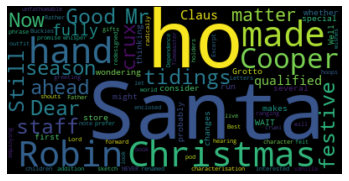

In [279]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [280]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [281]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [282]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [283]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [0]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [285]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

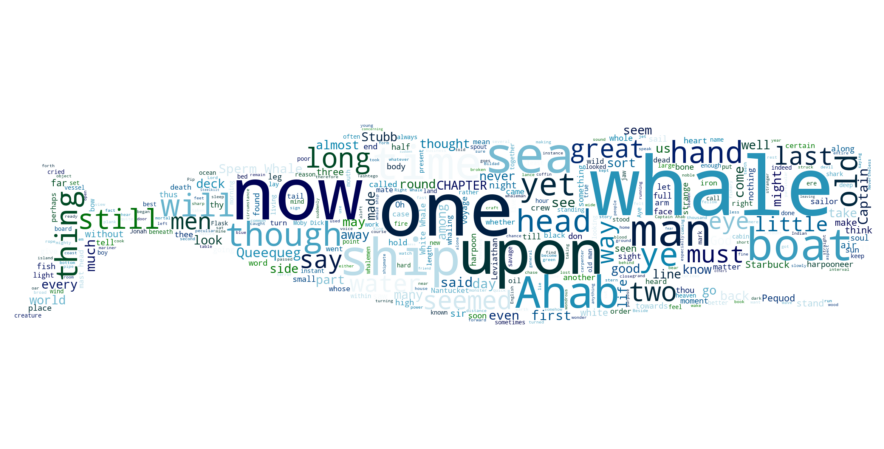

In [286]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) # we get white blank
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # this converts the image object into an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [287]:
rgb_array.shape # 1024x2048 is the resolution of the image and 3 is the RGB

(1024, 2048, 3)

In [288]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [289]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

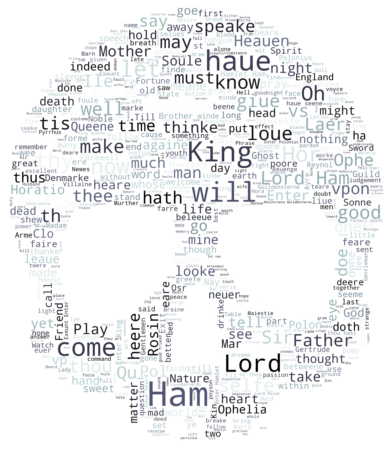

In [290]:
# Same task for Shakespeare's novel Hamlet
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## __Word Cloud of Ham and Spam Messages__

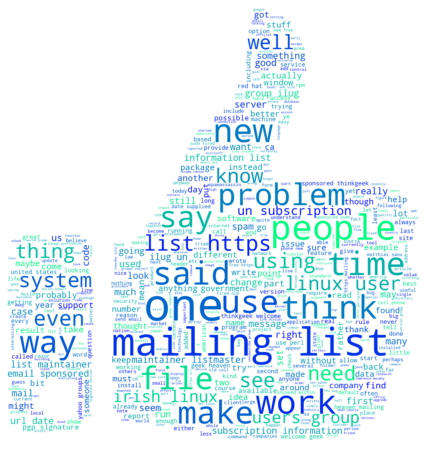

In [291]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) # we get white blank
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # this converts the image object into an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words=500, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

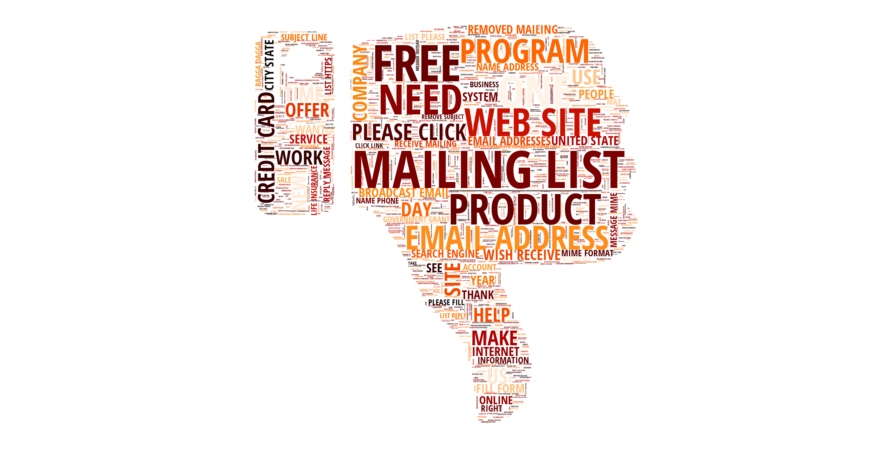

In [294]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) # we get white blank
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # this converts the image object into an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300, 
                       max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## __Generate Vocabulary & Dictionary__

In [296]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [298]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27294


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [301]:
# Create a subset of the series called 'frequent_words' that only contain
# the most common 2,500 words out of the total. Print them out.
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


In [302]:
type(frequent_words)

pandas.core.series.Series

### __Create Vocabulary DataFrame with a WORD_ID__

In [304]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## __Save the Vocabulary as a CSV File__

In [0]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## __Excercise: Checking if a Word is Part of the Vocabulary__

In [315]:
# The code should return True if the word in vocabulary and False otherwise
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'
any(vocab.VOCAB_WORD == 'data') # inefficient

True

In [322]:
'brew' in set(vocab.VOCAB_WORD)

False

## __Excercise: Find the Email with the Most Number of Words__

In [0]:
# Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. 
# Print out the stemmed list of words in the longest email. 
# Print out the longest email from the dataframe.

# Hint: use the len() function and practice list compehension.

In [0]:
# For loop
clean_email_length = []
for sublist in stemmed_nested_list:
  clean_email_length.append(len(sublist))

In [326]:
print(clean_email_length)

[39, 14, 153, 74, 34, 34, 256, 43, 139, 105, 43, 15, 169, 187, 74, 78, 226, 75, 224, 117, 83, 167, 46, 208, 192, 68, 361, 110, 142, 18, 129, 43, 50, 330, 14, 509, 152, 55, 258, 509, 2, 208, 96, 20, 185, 94, 149, 269, 14, 36, 1480, 1, 38, 312, 100, 9, 157, 70, 202, 34, 8, 161, 0, 33, 0, 92, 256, 276, 61, 81, 132, 21, 70, 184, 81, 175, 1389, 835, 25, 196, 117, 6072, 168, 72, 44, 274, 95, 98, 0, 0, 50, 47, 93, 3, 52, 65, 56, 146, 44, 273, 76, 41, 81, 115, 47, 50, 341, 19, 78, 426, 258, 1060, 86, 1262, 151, 60, 319, 19, 112, 111, 164, 572, 92, 1262, 8, 247, 49, 72, 117, 215, 114, 58, 0, 61, 185, 9, 71, 82, 47, 57, 58, 79, 161, 80, 50, 3, 38, 317, 58, 2, 178, 1460, 256, 175, 28, 210, 185, 0, 50, 40, 150, 44, 226, 20, 157, 47, 177, 6, 140, 18, 51, 73, 128, 18, 48, 72, 92, 0, 60, 104, 458, 129, 60, 94, 36, 170, 123, 51, 56, 47, 24, 74, 274, 27, 14, 15, 24, 102, 227, 108, 333, 0, 79, 36, 258, 54, 14, 247, 62, 0, 157, 1216, 117, 479, 58, 217, 77, 104, 108, 97, 421, 329, 58, 0, 226, 177, 748, 68

In [327]:
# Python List Comprehension
clean_email_length = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the lonest email:', max(clean_email_length))

Nr words in the lonest email: 7661


In [328]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_length))

Email position in the list (and the data dataframe) 5424


In [329]:
stemmed_nested_list[np.argmax(clean_email_length)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [330]:
data.at[np.argmax(clean_email_length), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## __Generate Features & a Sparse Matrix__
### __Creating a DataFrame with one word per Column__

In [334]:
type(stemmed_nested_list)

pandas.core.series.Series

In [335]:
type(stemmed_nested_list.to_list())

list

In [336]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,remov,instruct,saw,list,internet,work,compani,submit,websit,search,engin,submit,websit,world,best,search,engin,directori,one,time,charg,would,like,put,websit,fast,lane,receiv,traffic,call,number,list,work,verifi,sincer,brian,frank,remov,ext,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,copyright,right,reservedif,would,longer,like,contact,feel,havereceiv,email,error,pleas,click,unsubscrib,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,help,find,fund,ltc,altern,market,agent,compani,place,ltc,declin,alzheim,heart,attack,diabet,parkinson,offer,guarante,issu,disabl,benefit,client,tax,advantag,underwrit,help,find,fund,long,term,care,altern,client,make,addit,commiss,bonu,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,winner,dear,travel,congratul,may,one,lucki,winner,may,spend,next,vacat,beauti,orlando,florida,day,night,accommod,sunni,orlando,florida,round,trip,airfar,includ,two,rental,car,unlimit,mileag,day,pass,univers,studio,coupon,book,meal,entertain,casino,cruis,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,messag,mime,format,gener,per,gener,price,packag,differ,ship,handl,free,prescript,requir,ship,consult,fee,wish,receiv,mail,us,pleas,follow,link,remov,ensur,never,receiv,email,system,apologis,inconveni,may,caus,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [337]:
word_columns_df.shape

(5796, 7661)

### __Splitting the Data into a Training and Testing Dataset__

In [0]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, 
                                                    test_size=0.3, random_state=42)

In [340]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of the training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of the training set 0.6999654934437544


In [347]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOC_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4844,wed,aug,hettinga,wrote,pm,adam,back,wrote,palladium,palladi,antonym,odyssield,rhyme,shield,http,odysseu,first,learn,palladium,oracl,seer,hellenu,odysseu,neutralis,neutronis,palladium,defenc,troy,odysseu,invent,first,trojan,hors,incident,public,revel,palladium,suppos,seventh,day,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4727,hi,folk,maintain,coloc,server,behalf,small,group,individu,look,backup,solut,possibl,get,sort,end,intern,tape,solut,could,use,back,approx,gig,data,dream,isp,offer,backup,extra,cost,problem,well,extra,cost,hope,instal,kind,intern,tape,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5022,j,jon,write,j,anyon,consid,fact,occurr,appear,j,increas,awar,mayb,public,surround,j,certain,agenc,grant,fund,j,like,see,data,show,increas,j,seen,data,show,rock,size,smaller,crash,ottawa,sky,background,nois,plot,data,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3504,wow,talk,pheenomeenon,http,amithisornot,dynam,peer,rate,system,tool,help,build,x,site,get,basic,version,basic,version,let,build,specif,x,site,exampl,licens,cover,singl,instal,singl,site,advanc,version,advanc,version,let,user,creat,x,site,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3921,good,day,fox,fri,aug,fox,wrote,recent,instal,razor,start,use,find,necessari,whitelist,mail,list,yahoogroup,ca,whitelist,address,person,make,post,whitelist,anoth,field,modifi,code,wonder,someon,care,submiss,bad,mail,list,drop,bad,mail,address,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [348]:
y_train.head() # our ids match to each other

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### __Create a Sparse Matrix for the Training Data__

In [0]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [353]:
word_index.get_loc('thu') # position of the word

395

In [0]:
def make_sparse_matrix(df, indexed_words, labels):
  '''
  Returns sparse matrix as dataframe.

  df: A dataframe with words in the columns with a document id as an index(X_train or X_test)

  indexed_words: index of words ordered by word id

  labels: category as a series (y_train or y_test)
  '''

  nr_rows = df.shape[0]
  nr_cols = df.shape[1]
  word_set = set(indexed_words)
  dict_list = []

  for i in range(nr_rows):
    for j in range(nr_cols):

      word = df.iat[i, j]
      if word in word_set:
        doc_id = df.index[i]
        word_id = indexed_words.get_loc(word)
        category = labels.at[doc_id]

        item = {'LABEL': category, 'DOC_ID': doc_id, 
                'OCCURENCE': 1, 'WORD_ID': word_id}
        
        dict_list.append(item)

  return pd.DataFrame(dict_list) 



In [355]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 3min 13s, sys: 239 ms, total: 3min 13s
Wall time: 3min 13s


In [356]:
sparse_train_df.shape

(438220, 4)

In [357]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,541
1,0,4844,1,253
2,0,4844,1,1135
3,0,4844,1,37
4,0,4844,1,503


In [358]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
438215,1,860,1,250
438216,1,860,1,0
438217,1,860,1,5
438218,1,860,1,2
438219,1,860,1,0


## __Combine Occurences with the Pandas groupby() Method__

In [370]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              2
       6       1              1
       8       1              1
       9       1              2
       12      1              1

In [369]:
vocab.at[2, 'VOCAB_WORD']

'list'

In [365]:
data.MESSAGE[0]

'Removal instructions below\n\n\n\n\n\nI saw your listing on the internet.  I work\n\nfor a company that submits websites to search\n\nengines.  We can submit your website to over\n\n350 of the worlds best search engines and \n\ndirectories for a one time charge of only\n\n$39.95.  \n\n\n\nIf you would like to put your website in \n\nthe fast lane and receive more\n\ntraffic call me on our toll-free number\n\nlisted below.  \n\n\n\nAll work is verified!\n\n \n\nSincerely,\n\n \n\nBrian Franks\n\n888-532-8842\n\n\n\n\n\n\n\nTo be removed call:888-800-6339 Ext. 1377\n\n\n\n\n'

In [371]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,2
1,0,6,1,1
2,0,8,1,1
3,0,9,1,2
4,0,12,1,1


In [372]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
263072,5795,1788,0,1
263073,5795,1856,0,1
263074,5795,2020,0,1
263075,5795,2048,0,1
263076,5795,2180,0,3


In [373]:
train_grouped.shape

(263077, 4)

### __Save Training Data as .txt File__

In [0]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

### __Working with Test Data__

In [377]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOC_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4675,chri,garrigu,date,wed,aug,ouch,get,right,robert,elz,date,wed,aug,ca,read,flist,totalcount,unseen,element,array,execut,flist,totalcount,mhprofil,flaginn,spool,iconspool,labelup,els,flaginn,icondown,labeldown,procedur,line,fix,cv,second,use,key,bind,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4220,use,perl,daili,newslett,issu,perl,meetup,perl,meetup,post,ziggi,thursday,septemb,news,http,davorg,write,peopl,meetup,set,perl,meetup,first,one,take,place,septemb,probabl,go,along,one,london,see,happen,interest,hear,opinion,achiev,exist,perl,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2484,need,experi,rip,sophist,code,mostli,histor,accid,deal,earli,version,tk,emac,cutbuff,wierd,junk,hack,upon,appropri,hal,devor,said,fri,sep,toni,toni,nugent,wrote,toni,ca,even,mark,text,exmh,messag,window,toni,past,termin,window,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2418,ander,eriksson,date,thu,aug,thu,aug,chri,chri,garrigu,wrote,chri,chri,ander,eriksson,date,thu,aug,oooop,work,got,startup,attempt,chang,fold,r,fail,chri,alreadi,found,check,chri,check,sent,chri,mail,hope,fast,enough,would,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5110,heh,never,mind,perfectli,good,desert,southwest,right,area,hot,desert,warfar,train,never,understand,e,cdale,wrote,okay,ammend,live,old,tree,save,like,thousand,acr,virgin,pine,forest,raze,ms,militari,practic,desert,warfar,fought,year,lost,stand,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [378]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [379]:
X_test.shape

(1739, 7661)

In [380]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 1min 21s, sys: 143 ms, total: 1min 21s
Wall time: 1min 21s


In [381]:
sparse_test_df.shape

(195751, 4)

In [0]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()

In [384]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,1,4
1,8,1,1,2
2,8,3,1,3
3,8,4,1,1
4,8,5,1,2


In [385]:
test_grouped.shape

(112829, 4)

In [0]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## __Summarinizing our Understanding__

 We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing.  

In [0]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [391]:
# The number of individual emails included in the train.txt file
len(train_doc_ids)

4023

In [394]:
# The number of individual emails included in the test.txt file
len(test_doc_ids)

1716

In [396]:
set(X_test.index.values) - test_doc_ids

{51,
 62,
 88,
 132,
 149,
 157,
 177,
 238,
 387,
 422,
 425,
 443,
 479,
 538,
 589,
 691,
 712,
 926,
 1030,
 1374,
 1666,
 1730,
 1737}

In [400]:
data.MESSAGE[132] # message looks like rubbish

'------=_NextPart_000_00B3_51A40A1A.A7486A51\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPCFET0NUWVBFIEhUTUwgUFVCTElDICItLy9XM0MvL0RURCBIVE1MIDQuMDEg\n\nVHJhbnNpdGlvbmFsLy9FTiI+DQo8aHRtbD4NCjxoZWFkPg0KPHRpdGxlPkFk\n\ndWx0IENsYXNzaWZpZWQgMmsyPC90aXRsZT4NCjxtZXRhIGh0dHAtZXF1aXY9\n\nIkNvbnRlbnQtVHlwZSIgY29udGVudD0idGV4dC9odG1sOyBjaGFyc2V0PWlz\n\nby04ODU5LTEiPg0KPC9oZWFkPg0KDQo8Ym9keSBiZ2NvbG9yPSIjRkZGRkZG\n\nIiBsaW5rPSIjQ0M5OTk5IiBsZWZ0bWFyZ2luPSIwIiB0b3BtYXJnaW49IjAi\n\nIG1hcmdpbndpZHRoPSIwIiBtYXJnaW5oZWlnaHQ9IjAiPg0KDQo8Y2VudGVy\n\nPg0KICA8YnI+DQogIDx0YWJsZSB3aWR0aD0iNjAwIiBib3JkZXI9IjAiIGNl\n\nbGxzcGFjaW5nPSIwIiBjZWxscGFkZGluZz0iMSI+DQogICAgPHRyPg0KICAg\n\nICAgPHRkIGJnY29sb3I9IiM5OTAwMDAiPjx0YWJsZSB3aWR0aD0iNjAwIiBi\n\nb3JkZXI9IjAiIGNlbGxzcGFjaW5nPSIwIiBjZWxscGFkZGluZz0iMCI+DQog\n\nICAgICAgICAgPHRyPg0KICAgICAgICAgICAgPHRkIGJnY29sb3I9IiNGRkZG\n\nRkYiPg0KICAgICAgICAgIA0KICAgICAgICAgIDxkaXYgYWxpZ249InJpZ2h0\n\nIj48aW1nIHNyYz0iaHR0cDovL3

In [402]:
data.loc[51] # we can find a file location in our folder by its name and check 
#if its a problem with reading or the message is a garbage

MESSAGE      ------=_NextPart_000_00E2_80E42E6E.B7623D35\n\...
CATEGORY                                                     1
FILE_NAME               00339.16bd110d8aa11e7d9398287c27b1b389
Name: 51, dtype: object

In [404]:
clean_msg_no_html(data.at[51, 'MESSAGE']) # so, this email hasn't been included in our dataset
#because it has no words from our vocabulary

['dqorkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']

__Conclusion__: _we pre-processed our data and now we have only numbers (no words anymore) that are ready to be fed into our classifier_